In [2]:
%pip install opencv-python-headless==4.9.0.80
%pip install mediapipe

import cv2, sys, os, math
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from typing import Tuple, Union
import pandas as pd

# mediapipe
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

print('import succesful')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2024-07-16 11:33:44.564736: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-16 11:33:44.606394: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 11:33:45.321705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


import succesful


### Utilities

#### Folder utilities

In [4]:
def remove_ipynb_checkpoints(starting_dir):
    for path in Path(starting_dir).rglob('.ipynb_checkpoints'):
        print("Removing directory:", path)
        for file in path.glob('*'):
            file.unlink()
        path.rmdir()
        
def manage_and_create_paths(image_path, out_path):
    resP = out_path / image_path.parent.name / image_path.name
    if not resP.parent.exists():
        resP.parent.mkdir(parents=True, exist_ok=True)
    return resP.parent

def create_output_path(path, out_path):
    rel = str(path).split('in/')[1]
    res_path = out_path / rel
    if not res_path.exists():
        res_path.parent.mkdir(parents=True, exist_ok=True)
    return res_path

#### Image utilities

In [5]:
def save_image(path, img):
    cv2.imwrite(path, img)

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

def read_cv2_image(image_path):
    return cv2.imread(str(image_path))

def read_mp_cv2_image(image_path):
    return mp.Image.create_from_file(str(image_path)), cv2.imread(str(image_path))

# convert png to jpg
def png_to_jpg(image_path):
    img = cv2.imread(str(image_path))
    jpg_path = str(image_path.with_suffix('.jpg'))
    cv2.imwrite(jpg_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    image_path.unlink()

# rename JPG
def rename_jpg_files(image_path):
    image_path = Path(image_path)
    new_path = image_path.with_suffix('.jpg')
    image_path.rename(new_path)

#### Preprocessing

In [6]:
# rescaling pixel values
def normalize(img):
    return img / 255.0

# histogram equalization
def histogram_eq(img):
    return cv2.equalizeHist(img)

# Normalization to zero mean and unit variance
def normalize_mean_var(img):
    mean, std = cv2.meanStdDev(img)
    return (img - mean) / std

# grascale conversion
def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# resizes images based on given size and interpolation method
def downsize_image(img, size):
    return cv2.resize(img, dsize=size, interpolation=cv2.INTER_AREA)

def upsize_image(img, size):
    return cv2.resize(img, dsize=size, interpolation=cv2.INTER_CUBIC)

# mediapipe face detection & cropping 
def crop_faces(img_cv2, detection_results, out_path):
    for d in detection_results.detections:  
        bbox = d.bounding_box
        origin_x, origin_y, width, height = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
        cropped_img = img_cv2[origin_y:origin_y+height, origin_x:origin_x+width]
        #show_image(cropped_img)      
        cv2.imwrite(str(out_path), cropped_img)
        return cropped_img
        

#### Mediapipe face detection

In [21]:
MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(normalized_x: float, 
                                     normalized_y: float, 
                                     image_width: int,
                                     image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and is_valid_normalized_value(normalized_y)):
    return None

  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(image, detection_result) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x, 
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

#### Mediapipe face mesh utilities

In [22]:
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title('Face Blendshapes')
  plt.tight_layout()
  plt.show()

# extract landmarks to csv
def extract_and_save_landmarks(c_df, img_cv2, idx):
    rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
    detection_result = detector_mesh.detect(rgb_frame)
    df = pd.DataFrame([(idx, p.name, index, point.x, point.y, point.z) for index, point in enumerate(detection_result.face_landmarks[0])], columns=['image_idx', 'image_name', 'landmark_idx', 'x', 'y', 'z'])
    c_df = c_df.append(df)
    return c_df

### Set parameters

#### Data paths

In [23]:
# INPUT
# images
afew_in = Path('/project/data/in/AFEW')
fer_in = Path('/project/data/in/FER-2013')
kdef_akdef_in = Path('/project/data/in/KDEF-AKDEF')
kdef_in = Path('/project/data/in/KDEF-AKDEF/KDEF_and_AKDEF/KDEF')
kdef_dyn_in = Path('/project/data/in/KDEF-dyn')
meld_in = Path('/project/data/in/MELD')
nimh_in = Path('/project/data/in/NIMH-CHEFS')

# videos
emoreact_in = Path('/project/data/in/EmoReact_V_1.0/Data/Train')

# OUTPUT
# images
afew_out = Path('/project/data/out/AFEW')
fer_out = Path('/project/data/out/FER-2013')
kdef_akdef_out = Path('/project/data/out/KDEF-AKDEF')
kdef_out = Path('/project/data/out/KDEF-AKDEF/KDEF_and_AKDEF/KDEF')
kdef_dyn_out = Path('/project/data/out/KDEF-dyn')
meld_out = Path('/project/data/out/MELD')
nimh_out = Path('/project/data/out/NIMH-CHEFS')

# videos
emoreact_out = Path('/project/data/out/EmoReact_V_1.0/Data/Train')

# general
data_in = Path('/project/data/in')
data_out = Path('/project/data/out')

# features
feature_path = Path('/project/data/features/')

#### Model path & options

In [34]:
model_path_detect = '/home/jovyan/work/models/blaze_face_short_range.tflite'
model_path_mesh = '/home/jovyan/work/models/face_landmarker.task'

base_options_detect = python.BaseOptions(model_asset_path=model_path_detect)
options_detect = vision.FaceDetectorOptions(base_options=base_options_detect)
detector_detect = vision.FaceDetector.create_from_options(options_detect)

base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
options_mesh = vision.FaceLandmarkerOptions(base_options=base_options_mesh,
                                       output_face_blendshapes=False,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector_mesh = vision.FaceLandmarker.create_from_options(options_mesh)

I0000 00:00:1719832290.738896     172 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1719832290.749839   11532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1719832290.753482     172 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1719832290.755831     172 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1719832290.768920   11543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719832290.781853   11558 inference_feedback_manager.cc:114] F

## Example

In [35]:
PATH = Path('/home/jovyan/work/data/out/EmoReact')
IMAGES = list(PATH.rglob('*.jpg'))


In [36]:
print(IMAGES[0])

/home/jovyan/work/data/out/EmoReact/test/Curiosity/80'sTOYS105_2_frame_3_face_0.jpg


In [39]:


path = (IMAGES[0])

img_mp, img_cv2 = read_mp_cv2_image(path)



#### Face detection

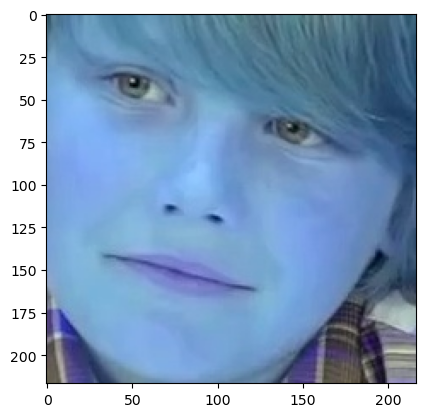

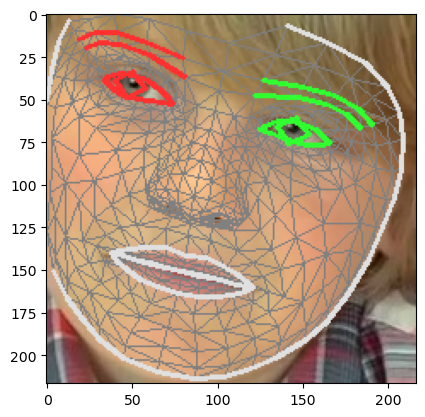

In [42]:


# face detection & crop
detection_results = detector_detect.detect(img_mp)
cropped_img = crop_faces(img_cv2, detection_results, '/home/jovyan/work/cropped.jpg')
show_image(cropped_img)

# face mesh
rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
detection_result = detector_mesh.detect(rgb_frame)
annotated_image = draw_landmarks_on_image(rgb_frame.numpy_view(), detection_result)
res_img = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
show_image(res_img)

## Preprocessing

In [6]:
remove_ipynb_checkpoints('.')

NameError: name 'remove_ipynb_checkpoints' is not defined

#### Convert to jpg:

In [16]:
for p in tqdm(list(data_in.rglob('*.png'))):
    png_to_jpg(p)
display('done')

0it [00:00, ?it/s]


'done'

#### JPG -> jpg:

In [14]:
def rename_jpg_files(image_path):
    new_path = image_path.with_suffix('.jpg')
    image_path.rename(new_path)

In [15]:
path = Path('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/')
print(list(path.rglob('*.JPG')))

[PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20SUS.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20SUHR.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20DIFR.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20HAFL.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20DIHL.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20HAHR.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20HAS.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20SUFL.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20SAS.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20NEFL.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20SAFR.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20ANS.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM20/BM20DIS.JPG'), PosixPath('/project/volume/data/out/KDEF-AKDEF/KDEF/BM2

In [28]:
path = Path('/project/BM20SUHR.JPG')

new_path = path.with_suffix('.jpg')
path.rename(new_path)


PosixPath('/project/BM20SUHR.jpg')

In [16]:
for p in tqdm(list(path.rglob('*.JPG'))):  
    rename_jpg_files(p)
display('done')

100%|████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 3485.63it/s]


'done'

#### Run face detection and cropping:

In [96]:
for p in tqdm(list(kdef_in.rglob('*.jpg'))): 
    path = create_output_path(p, data_out)
    #print(path)
    img_mp, img_cv2 = read_mp_cv2_image(p)
    img_cv2 = convert_to_grayscale(img_cv2)
    #show_image(img_cv2)
    detection_results = detector_detect.detect(img_mp)
    #print(detection_results.detections)
    crop_faces(img_cv2, detection_results, path)
display('done')

100%|██████████| 4900/4900 [02:39<00:00, 30.76it/s]


'done'

#### Run the rest of the preprocessing as needed:

In [108]:
for p in tqdm(list(data_out.rglob('*.jpg'))):
    #path = create_output_path(p, nimh_out)
    img = read_cv2_image(p)
    
    img = downsize_image(img, size)

    #img = convert_to_grayscale(img)
    #img = histogram_eq(img) # needs grayscale to work
    
    # TODO: fix these both
    #img = normalize_mean_var(img) # results in black image?
    #img = normalize(img) # results in black image?

    save_image(str(p), img)
display('done')

100%|██████████| 58215/58215 [04:00<00:00, 241.60it/s]


'done'

## Feature extraction (facial landmarks)

In [1]:
def csv_output_path(path):
    rel = Path(str(path).split('out/')[1]).with_suffix('.csv')
    res = feature_path / rel
    if not res.exists():
        res.parent.mkdir(parents=True, exist_ok=True)
    return res

In [2]:
# specify the path for feature extraction
path = afew_out

NameError: name 'afew_out' is not defined

In [ ]:
c_df = pd.DataFrame()

for i, path in enumerate(tqdm(list(path.rglob('*.jpg')))):    
    res_path = csv_output_path(path)
    _, img_cv2 = read_mp_cv2_image(path)
    #show_image(img_cv2)
    try:
        c_df = extract_and_save_landmarks(c_df, img_cv2, i)
    except IndexError:
        pass
    c_df.to_csv(str(res_path), index=False)

display('done')

afew - todo
fer-2013 - todo
kdef - todo
nimh-chefs - todo

In [3]:
images = list(Path('/home/jovyan/work/data/out/KDEF-AKDEF').rglob('*.jpg'))

In [ ]:
image